In [1]:
from resnet_builder import resnet
import keras
import os
import glob
import numpy as np
from keras.preprocessing.image import  img_to_array, load_img
from PIL import Image
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
dict_labels = {"daisy":0, "dandelion":1, "rose": 2, "sunflower":3, "tulip": 4}
size = (128, 128)
nbofdata=700
base_path = r'ml100-03-final/image_data/train/'
layers_of_folders=0
folder_list=[]    
labels=['daisy','dandelion', 'rose', 'sunflower', 'tulip']

if base_path :
    folder_layers=[]
    files = os.scandir(base_path)
    #  Get the 1st layer of folder
    first_folder = []
    first_folder_kind = []
    for entry in files:
        if entry.is_dir():
            first_folder.append(entry.path)
            first_folder_kind.append(entry.name)
    folder_layers.append(first_folder_kind)
    folder_list.append(first_folder)

In [22]:
datanumber=nbofdata
blob=[]
blob_nparray=[]
image_data=[]
conc = 0
labels_dict={}
fnamelist = {}
for entry1 in folder_list[layers_of_folders - 1]:
    blob = []
    cellname = os.path.basename(os.path.dirname(entry1))  # extract cell name
    # print(cellname)
    concnames = os.path.basename(entry1)  # extract concentration
    # print(concnames)
    if concnames in labels:
        labels_dict[conc] = concnames
        fnamelist = glob.glob(os.path.join(entry1, '*.jpg'))
        for filename in fnamelist[0:datanumber]:
            im = Image.open(filename)
            if im is not None:
                if im.mode=='RGB':
                    im=im.resize(size,Image.BILINEAR)
                    imarray = np.array(im)
                    blob.append(imarray)
        ind = np.reshape(np.arange(1, len(blob) + 1), (-1, 1))
        blob_nparray = np.reshape(np.asarray(blob), (len(blob), blob[1].size))
        blob_nparray = np.hstack((blob_nparray, ind, conc * np.ones((len(blob), 1))))
        image_data.append(np.asarray(blob_nparray, dtype=np.float32))
        print(concnames+'  finished!')
        conc += 1

sunflower  finished!
tulip  finished!
dandelion  finished!
daisy  finished!
rose  finished!


In [26]:
for j in range(len(labels)):
    print(j)
    trytry=image_data[j][:]
# Prepare data
    LengthT = trytry.shape[0]
    trytry_index = trytry[...,-2:-1]
    trytry_label = trytry[...,-1:] #['Nega' for x in range(lengthN*4)] #Nega_data[...,-1:]
    trytry = trytry[...,:-2]
    
    # Normalize image by subtracting mean image
    trytry -= np.reshape(np.mean(trytry, axis=1), (-1,1))
    # Reshape images
    trytry = np.reshape(trytry, (trytry.shape[0],128,128,3))
    
#    # Rotate images
#    for i in range(3):
#        trytry[LengthT*(i+1):LengthT*(i+2)] = np.rot90(trytry[:LengthT], i+1, (1,2))
    # Add channel dimension to fit in Conv2D
    trytry = trytry.reshape(-1,128,128,3)
    trytry_train_upto = round(trytry.shape[0] * 8 / 10)
    print(trytry_train_upto)
    trytry_test_upto = trytry.shape[0]
    if j is 0:
        train_data = trytry[:trytry_train_upto]
        test_data = trytry[trytry_train_upto:trytry_test_upto]
        train_label = trytry_label[:trytry_train_upto]
        test_label = trytry_label[trytry_train_upto:trytry_test_upto]
        
    else:
        train_data = np.concatenate((train_data, 
                                     trytry[:trytry_train_upto]), axis=0)
        
        test_data = np.concatenate((test_data, 
                                    trytry[trytry_train_upto:trytry_test_upto]), axis=0)
        
        train_label = np.concatenate((train_label, 
                                     trytry_label[:trytry_train_upto]), axis=0)
        
        
        test_label = np.concatenate((test_label, 
                                    trytry_label[trytry_train_upto:trytry_test_upto]), axis=0)
        
test_label = keras.utils.to_categorical(test_label, num_classes=len(labels))
train_label = keras.utils.to_categorical(train_label, num_classes=len(labels))

0
390
1
506
2
550
3
400
4
412


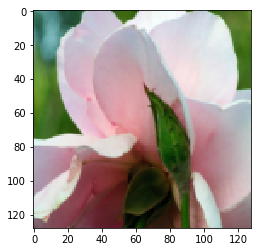

In [34]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import array_to_img

plt.imshow(array_to_img(train_data[2200]))
plt.show()

In [18]:
fnamelist[0]

'ml100-03-final/image_data/train/rose/4b2112b133be1c62d64531b0775a284e.jpg'

In [33]:
train_label[2200]

array([0., 0., 0., 0., 1.], dtype=float32)

In [5]:
import random
temp = list(zip(train_data, train_label))

random.shuffle(temp)

train_data,train_label = zip(*temp)

train_data=np.asarray(train_data)
train_label=np.asarray(train_label)

In [6]:
model = resnet(input_shape=(128,128,3))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [7]:
from keras.optimizers import Adam

batch_size = 128
num_classes = 5 
epochs = 30
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(train_data, train_label,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(test_data, test_label))
score = model.evaluate(test_data, test_label, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 2258 samples, validate on 565 samples
Epoch 1/30
2258/2258 [==============================] - 473s 209ms/step - loss: 1.9608 - accuracy: 0.4535 - val_loss: 147.1553 - val_accuracy: 0.1770
Epoch 2/30
2258/2258 [==============================] - 477s 211ms/step - loss: 1.5874 - accuracy: 0.6112 - val_loss: 45.3440 - val_accuracy: 0.1912
Epoch 3/30
2258/2258 [==============================] - 462s 205ms/step - loss: 1.4819 - accuracy: 0.6546 - val_loss: 19.7853 - val_accuracy: 0.1965
Epoch 4/30
2258/2258 [==============================] - 469s 208ms/step - loss: 1.3565 - accuracy: 0.7099 - val_loss: 7.4509 - val_accuracy: 0.2885
Epoch 5/30
2258/2258 [==============================] - 473s 209ms/step - loss: 1.2672 - accuracy: 0.7471 - val_loss: 4.7770 - val_accuracy: 0.3487
Epoch 6/30
2258/2258 [==============================] - 466s 207ms/step - loss: 1.1938 - accuracy: 0.7759 - val_loss: 2.0945 - val_accuracy: 0.5221
Epoch 7/30
2258/2258 [==============================] - 468s 

In [8]:
model.save('flower_resnet_model.h5')

In [35]:
dict_labels = {"test":0}
size = (128, 128)
nbofdata=2000
base_path = r'ml100-03-final/image_data/test/'
layers_of_folders=0
folder_list=[]    
labels=['test']

if base_path :
    folder_layers=[]
    files = os.scandir(base_path)
    #  Get the 1st layer of folder
    first_folder = []
    first_folder_kind = []
    for entry in files:
        if entry.is_dir():
            first_folder.append(entry.path)
            first_folder_kind.append(entry.name)
    folder_layers.append(first_folder_kind)
    folder_list.append(first_folder)

In [36]:
datanumber=nbofdata
blob=[]
blob_nparray=[]
image_data=[]
conc = 0
fc = 0
labels_dict={}
fn = {}
for entry1 in folder_list[layers_of_folders - 1]:
    blob = []
    cellname = os.path.basename(os.path.dirname(entry1))  # extract cell name
    # print(cellname)
    concnames = os.path.basename(entry1)  # extract concentration
    # print(concnames)
    if concnames in labels:
        labels_dict[conc] = concnames
        fnamelist = glob.glob(os.path.join(entry1, '*.jpg'))
        for filename in fnamelist[0:datanumber]:
            im = Image.open(filename)
            if im is not None:
                if im.mode=='RGB':
                    im=im.resize(size,Image.BILINEAR)
                    imarray = np.array(im)
                    blob.append(imarray)
                    fn[fc] = filename
                    fc += 1
        ind = np.reshape(np.arange(1, len(blob) + 1), (-1, 1))
        blob_nparray = np.reshape(np.asarray(blob), (len(blob), blob[1].size))
        blob_nparray = np.hstack((blob_nparray, ind, conc * np.ones((len(blob), 1))))
        image_data.append(np.asarray(blob_nparray, dtype=np.float32))
        print(ind)
        print(blob_nparray)
        print(concnames+'  finished!')
        conc += 1

[[   1]
 [   2]
 [   3]
 ...
 [1998]
 [1999]
 [2000]]
[[1.150e+02 1.050e+02 9.000e+00 ... 3.000e+00 1.000e+00 0.000e+00]
 [1.970e+02 2.150e+02 2.240e+02 ... 4.800e+01 2.000e+00 0.000e+00]
 [3.500e+01 6.100e+01 3.600e+01 ... 3.200e+01 3.000e+00 0.000e+00]
 ...
 [1.080e+02 1.230e+02 3.000e+01 ... 0.000e+00 1.998e+03 0.000e+00]
 [1.390e+02 1.720e+02 1.990e+02 ... 1.000e+00 1.999e+03 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 1.000e+00 2.000e+03 0.000e+00]]
test  finished!


In [37]:
fn[0]

'ml100-03-final/image_data/test/test/b38d1fef59f487bf8e702c5eab79880d.jpg'

In [38]:
sp = {}
for i in range(2000):
    sp[i] = fn[i].split('/')
    sp[i] = sp[i][4].split('.jpg')

In [39]:
for i in range(10):
    print(sp[i][0])

b38d1fef59f487bf8e702c5eab79880d
4cd32ea34f68e3b43c73341b8fb3d4c0
aabbd368642e6843bb6f15a3afaa9ed0
71469fb90f914a3639e7691ea2a64214
6c6fc0a1bd638792e341c75949c76428
fd2580a8f500b27baf6913759b29c003
499790bb426abd7f293270ff2a357984
d79a3d0a0e8120333f1ea82aaaad1dd0
ff7eac29b6d7a33fbd8009677c3e9c58
8ceefea6d56655f1689ae14a20c0f8be


In [40]:
ids = {}
for i in range(2000):
    ids[i] = sp[i][0]

In [41]:
for j in range(len(labels)):
    trytry=image_data[j][:]
# Prepare data
    LengthT = trytry.shape[0]

    trytry_index = trytry[...,-2:-1]

    trytry_label = trytry[...,-1:] #['Nega' for x in range(lengthN*4)] #Nega_data[...,-1:]

    trytry = trytry[...,:-2]

    # Normalize image by subtracting mean image
    trytry -= np.reshape(np.mean(trytry, axis=1), (-1,1))
    # Reshape images
    trytry = np.reshape(trytry, (trytry.shape[0],128,128,3))
    
#    # Rotate images
#    for i in range(3):
#        trytry[LengthT*(i+1):LengthT*(i+2)] = np.rot90(trytry[:LengthT], i+1, (1,2))
    # Add channel dimension to fit in Conv2D
    trytry = trytry.reshape(-1,128,128,3)
    trytry_test_upto = trytry.shape[0]
    if j is 0:
        test_data = trytry[:trytry_test_upto]      
    else:     
        test_data = np.concatenate((test_data, 
                                    trytry[trytry_train_upto:trytry_test_upto]), axis=0)

In [42]:
test_data.shape

(2000, 128, 128, 3)

In [43]:
predictions=model.predict(test_data)

In [44]:
for i in range(10):
    for j in range(5):
        print(predictions[i][j])

2.2243052e-05
6.8373897e-06
0.00022687392
0.99973017
1.38684245e-05
0.9987633
0.0005352315
0.00066286017
3.2647492e-06
3.5462235e-05
8.537149e-06
0.0022405272
0.997672
3.9619415e-05
3.9253402e-05
0.99723923
0.0024499174
0.00024500806
1.0360521e-06
6.4740016e-05
0.0048408294
0.00016352149
0.97546726
0.003832197
0.015696192
0.00010770708
8.6866734e-05
0.053468365
0.94622296
0.000114122435
0.9997962
7.509939e-05
2.9889203e-05
5.622947e-05
4.2575582e-05
2.248006e-05
0.52489704
0.0009315679
0.0006625383
0.47348645
2.9828274e-05
0.0010564318
0.99858165
0.00021048679
0.00012171183
0.0058028647
0.72745854
0.04783529
0.00082321424
0.21808009


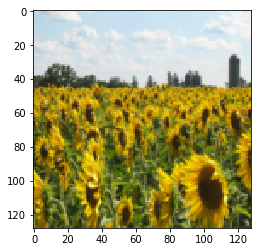

In [45]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import array_to_img

plt.imshow(array_to_img(test_data[1]))
plt.show()

In [47]:
cnn_pred = {}
for i in range(2000):
    for j in range(5):
        if predictions[i][j] == np.max(predictions[i]):
            if j == 0:
                cnn_pred[i] = 3
            if j == 1:
                cnn_pred[i] = 4
            if j == 2:
                cnn_pred[i] = 1
            if j == 3:
                cnn_pred[i] = 0
            if j == 4:
                cnn_pred[i] = 2

In [48]:
cnn_pred

{0: 0,
 1: 3,
 2: 1,
 3: 3,
 4: 1,
 5: 0,
 6: 3,
 7: 4,
 8: 1,
 9: 4,
 10: 1,
 11: 2,
 12: 4,
 13: 1,
 14: 0,
 15: 4,
 16: 1,
 17: 1,
 18: 1,
 19: 2,
 20: 1,
 21: 0,
 22: 4,
 23: 4,
 24: 3,
 25: 4,
 26: 1,
 27: 4,
 28: 0,
 29: 4,
 30: 4,
 31: 2,
 32: 4,
 33: 3,
 34: 4,
 35: 1,
 36: 2,
 37: 4,
 38: 1,
 39: 1,
 40: 2,
 41: 2,
 42: 1,
 43: 4,
 44: 1,
 45: 3,
 46: 1,
 47: 0,
 48: 1,
 49: 1,
 50: 3,
 51: 3,
 52: 2,
 53: 1,
 54: 1,
 55: 3,
 56: 4,
 57: 4,
 58: 1,
 59: 2,
 60: 1,
 61: 1,
 62: 0,
 63: 1,
 64: 1,
 65: 0,
 66: 1,
 67: 3,
 68: 1,
 69: 2,
 70: 1,
 71: 0,
 72: 1,
 73: 4,
 74: 1,
 75: 2,
 76: 2,
 77: 1,
 78: 1,
 79: 4,
 80: 1,
 81: 3,
 82: 3,
 83: 3,
 84: 0,
 85: 1,
 86: 2,
 87: 1,
 88: 2,
 89: 2,
 90: 3,
 91: 2,
 92: 4,
 93: 4,
 94: 3,
 95: 2,
 96: 4,
 97: 1,
 98: 1,
 99: 1,
 100: 3,
 101: 1,
 102: 0,
 103: 4,
 104: 1,
 105: 1,
 106: 3,
 107: 2,
 108: 2,
 109: 3,
 110: 1,
 111: 4,
 112: 1,
 113: 1,
 114: 1,
 115: 2,
 116: 1,
 117: 2,
 118: 2,
 119: 1,
 120: 1,
 121: 1,
 122: 2,
 12

In [49]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

submit = pd.DataFrame({'id': ids, 'flower_class': cnn_pred})
header = ["id", "flower_class"]
submit.to_csv('cnn_resnet_predict.csv', columns = header, index=False)